# Imports

In [13]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch import optim
from torchvision.models import resnet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("darkgrid")

# Data Visualization

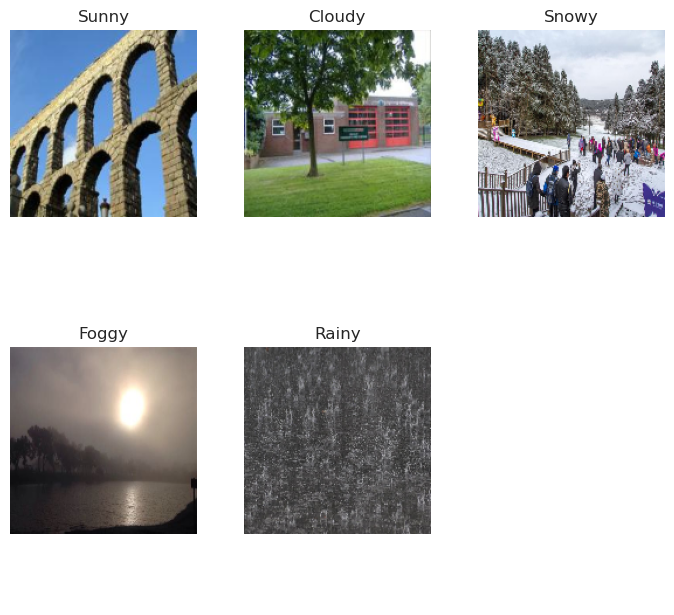

In [14]:
fig,axes=plt.subplots(2,3,figsize=(7,7))
plt.subplots_adjust(wspace=0)
ax=axes.flatten()
cls_dist={}

data_dir="/kaggle/input/5class-weather-status-image-classification/data"
for i,weather in enumerate(os.listdir(data_dir)):
    label=weather
    imgs=os.listdir(os.path.join(data_dir,weather))
    cls_dist[label]=len(imgs)

    img=cv2.imread(os.path.join(data_dir,weather,imgs[0]))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(160,160))
    ax[i].imshow(img)
    ax[i].set_title(f"{label.capitalize()}")
    ax[i].axis("off")

plt.tight_layout()
plt.axis("off")
plt.savefig("1.png");

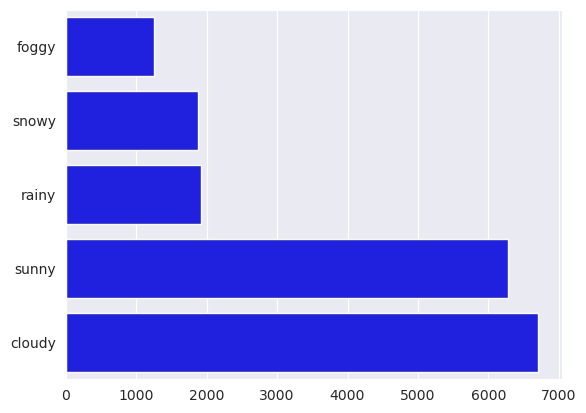

In [15]:
order=[i for i,y in sorted(cls_dist.items(),key=lambda kv:(kv[1],kv[0]))]
sns.barplot(x=list(cls_dist.values()),y=list(cls_dist.keys()),color="blue",order=order);
plt.savefig("2.png");

# Dataset and DataLoader

In [16]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [17]:
train_ds=ImageFolder(root=data_dir,transform=train_transforms)
val_ds=ImageFolder(root=data_dir,transform=val_transforms)

In [18]:
classes=train_ds.classes
classes

['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']

In [19]:
device=("cuda" if torch.cuda.is_available() else "cpu")
idx=list(range(len(train_ds)))

np.random.seed(42)
np.random.shuffle(idx)
train_idx=idx[:int(0.8*len(train_ds))]
val_idx=idx[int(0.8*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

batch_size =  32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2,
                      pin_memory=True if torch.cuda.is_available() else False)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2,
                    pin_memory=True if torch.cuda.is_available() else False)


#device = "cuda" if torch.cuda.is_available() else "cpu"
#idx = list(range(len(train_ds)))

#np.random.seed(42)
#np.random.shuffle(idx)
#train_idx = idx[:int(0.8 * len(train_ds))]
#val_idx = idx[int(0.8 * len(train_ds)):]

#train_ds = Subset(train_ds, train_idx)
#val_ds = Subset(val_ds, val_idx)

#batch_size = 32  # Change batch size to 32
#train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2,
                     # pin_memory=True if torch.cuda.is_available() else False)
#val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2,
                   # pin_memory=True if torch.cuda.is_available() else False)


In [20]:
print(device)

cuda


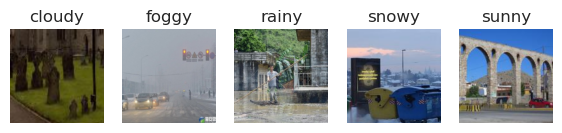

In [21]:
num_classes = 5
# Create a dictionary to store images for each class
class_images = {class_name: None for class_name in classes}

# Collect one image for each class
for i, (imgs, labels) in enumerate(train_dl):
    for img, label in zip(imgs, labels):
        class_name = classes[label.item()]
        if class_images[class_name] is None:
            class_images[class_name] = img
        if all(img is not None for img in class_images.values()):
            break
    if all(img is not None for img in class_images.values()):
        break

# Display the collected images
fig, axes = plt.subplots(1, num_classes, figsize=(7, 12))  # Adjust figsize as needed

for i, class_name in enumerate(class_images.keys()):
    ax = axes[i]
    img = class_images[class_name].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")

plt.savefig("one_image_per_class.png")


# Model

In [22]:
class WeatherResNet50(nn.Module):
    def __init__(self, num_classes):
        super(WeatherResNet50, self).__init__()
        self.resnet = resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        

    def forward(self, x):
        x = self.resnet(x)
        return x

# Define the model architecture
num_classes = 5  # Multi-label classification
model = WeatherResNet50(num_classes).to(device)

# Loss function for multi-label classification
#loss_fn = nn.BCEWithLogitsLoss()


In [23]:
for param in model.resnet.layer4.parameters():
    param.requires_grad = True


In [24]:
for param in model.resnet.fc.parameters():
    param.requires_grad = True

In [25]:
loss_fn = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.00001)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=1)


# Training

In [26]:
def epoch_cal(dataloader, mode):
    is_train = False
    epoch_loss = 0.0
    accuracy = 0.0
    length = len(dataloader.dataset)

    if mode == "train":
        model.train()
        is_train = True
    else:
        model.eval()

    with torch.set_grad_enabled(is_train):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            loss = loss_fn(output, labels)  # Use CrossEntropyLoss

            epoch_loss += loss.item()
            pred_labels = output.argmax(dim=1)
            accuracy += (labels == pred_labels).sum().item()

            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

    return epoch_loss / length, accuracy / length


In [27]:
epochs = 10
best_val_acc = 0.0
min_delta = 0.0005
patience = 10
best_epoch = 0
save_interval = 5  # Save checkpoint every 5 epochs

#try:
    # Load model and optimizer states if resuming from a previous session
    # Example: Uncomment these lines if you have model_checkpoint.pth and optimizer_checkpoint.pth files
    #model.load_state_dict(torch.load('/kaggle/working/model_checkpoint_29.pth'))
    #optimizer.load_state_dict(torch.load('/kaggle/working/optimizer_checkpoint_29.pth'))
#except Exception as e:
    #print("Error loading checkpoints:", e)


loss_dict = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):

    train_loss, train_acc = epoch_cal(train_dl, mode="train")
    loss_dict["train_loss"].append(train_loss)
    loss_dict["train_acc"].append(train_acc)

    #eval
    val_loss, val_acc = epoch_cal(val_dl, mode="eval")
    loss_dict["val_loss"].append(val_loss)
    loss_dict["val_acc"].append(val_acc)

    if val_acc >= best_val_acc + min_delta:
        best_epoch = epoch
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model.pth")

    if epoch - best_epoch > patience:
        print(f"Early Stopping training at: {epoch}")
        break

    lr_scheduler.step()

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), f'model_checkpoint_{epoch}.pth')
        torch.save(optimizer.state_dict(), f'optimizer_checkpoint_{epoch}.pth')

    print(f"{epoch}/{epochs}: Training\nloss: {train_loss} accuracy: {train_acc}")
    print(f"{epoch}/{epochs}: Evaluating\nloss: {val_loss} accuracy: {val_acc}")
    print("*" * 10, "\n")

0/10: Training
loss: 0.0245027503080031 accuracy: 0.716008316008316
0/10: Evaluating
loss: 0.014330114764543435 accuracy: 0.8531042128603105
********** 

1/10: Training
loss: 0.015148106572616456 accuracy: 0.8167013167013167
1/10: Evaluating
loss: 0.012051378981831862 accuracy: 0.8680709534368071
********** 

2/10: Training
loss: 0.013244383119702422 accuracy: 0.8428967428967429
2/10: Evaluating
loss: 0.010621374002151901 accuracy: 0.8805432372505543
********** 

3/10: Training
loss: 0.012041456122738738 accuracy: 0.8563409563409563
3/10: Evaluating
loss: 0.009110306934794275 accuracy: 0.9016075388026608
********** 

4/10: Training
loss: 0.011169841002907839 accuracy: 0.8664587664587664
4/10: Evaluating
loss: 0.009133327713116441 accuracy: 0.8952328159645233
********** 

5/10: Training
loss: 0.010600264741163327 accuracy: 0.8763686763686763
5/10: Evaluating
loss: 0.009448738904987894 accuracy: 0.8957871396895787
********** 

6/10: Training
loss: 0.010078798674372278 accuracy: 0.8776853

In [28]:
#import os

#Replace 'path/to/directory' with the actual path of the directory you want to clear
#directory_path = '/kaggle/working/'

#Iterate over files in the directory and delete them
#for filename in os.listdir(directory_path):
    #file_path = os.path.join(directory_path, filename)
    #if os.path.isfile(file_path):
        #os.remove(file_path)


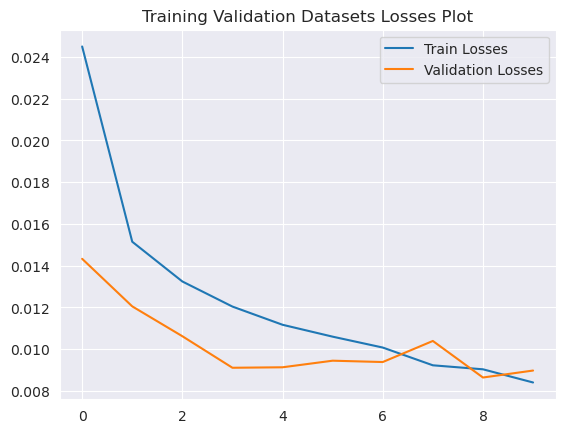

In [29]:
x=range(len(loss_dict['train_loss']))

sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();
plt.savefig("4.png")

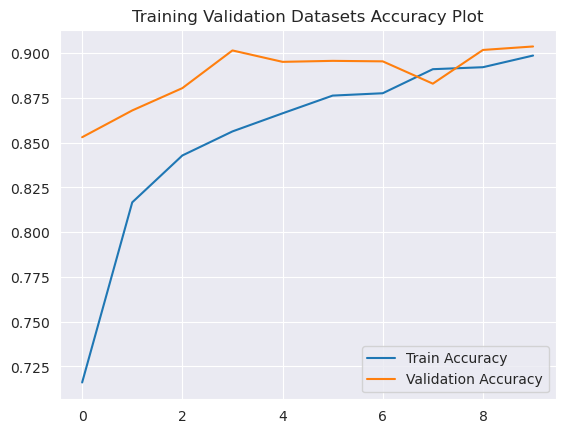

In [30]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();
plt.savefig("5.png")

# Deployment

In [31]:
num_classes = 5  # Number of classes
model = WeatherResNet50(num_classes)

# Load the trained model's state dictionary
device = torch.device("cpu")
state_dict = torch.load("/kaggle/working/model.pth", map_location=device)
model.load_state_dict(state_dict)

# Set the model in evaluation mode
model.eval()

WeatherResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

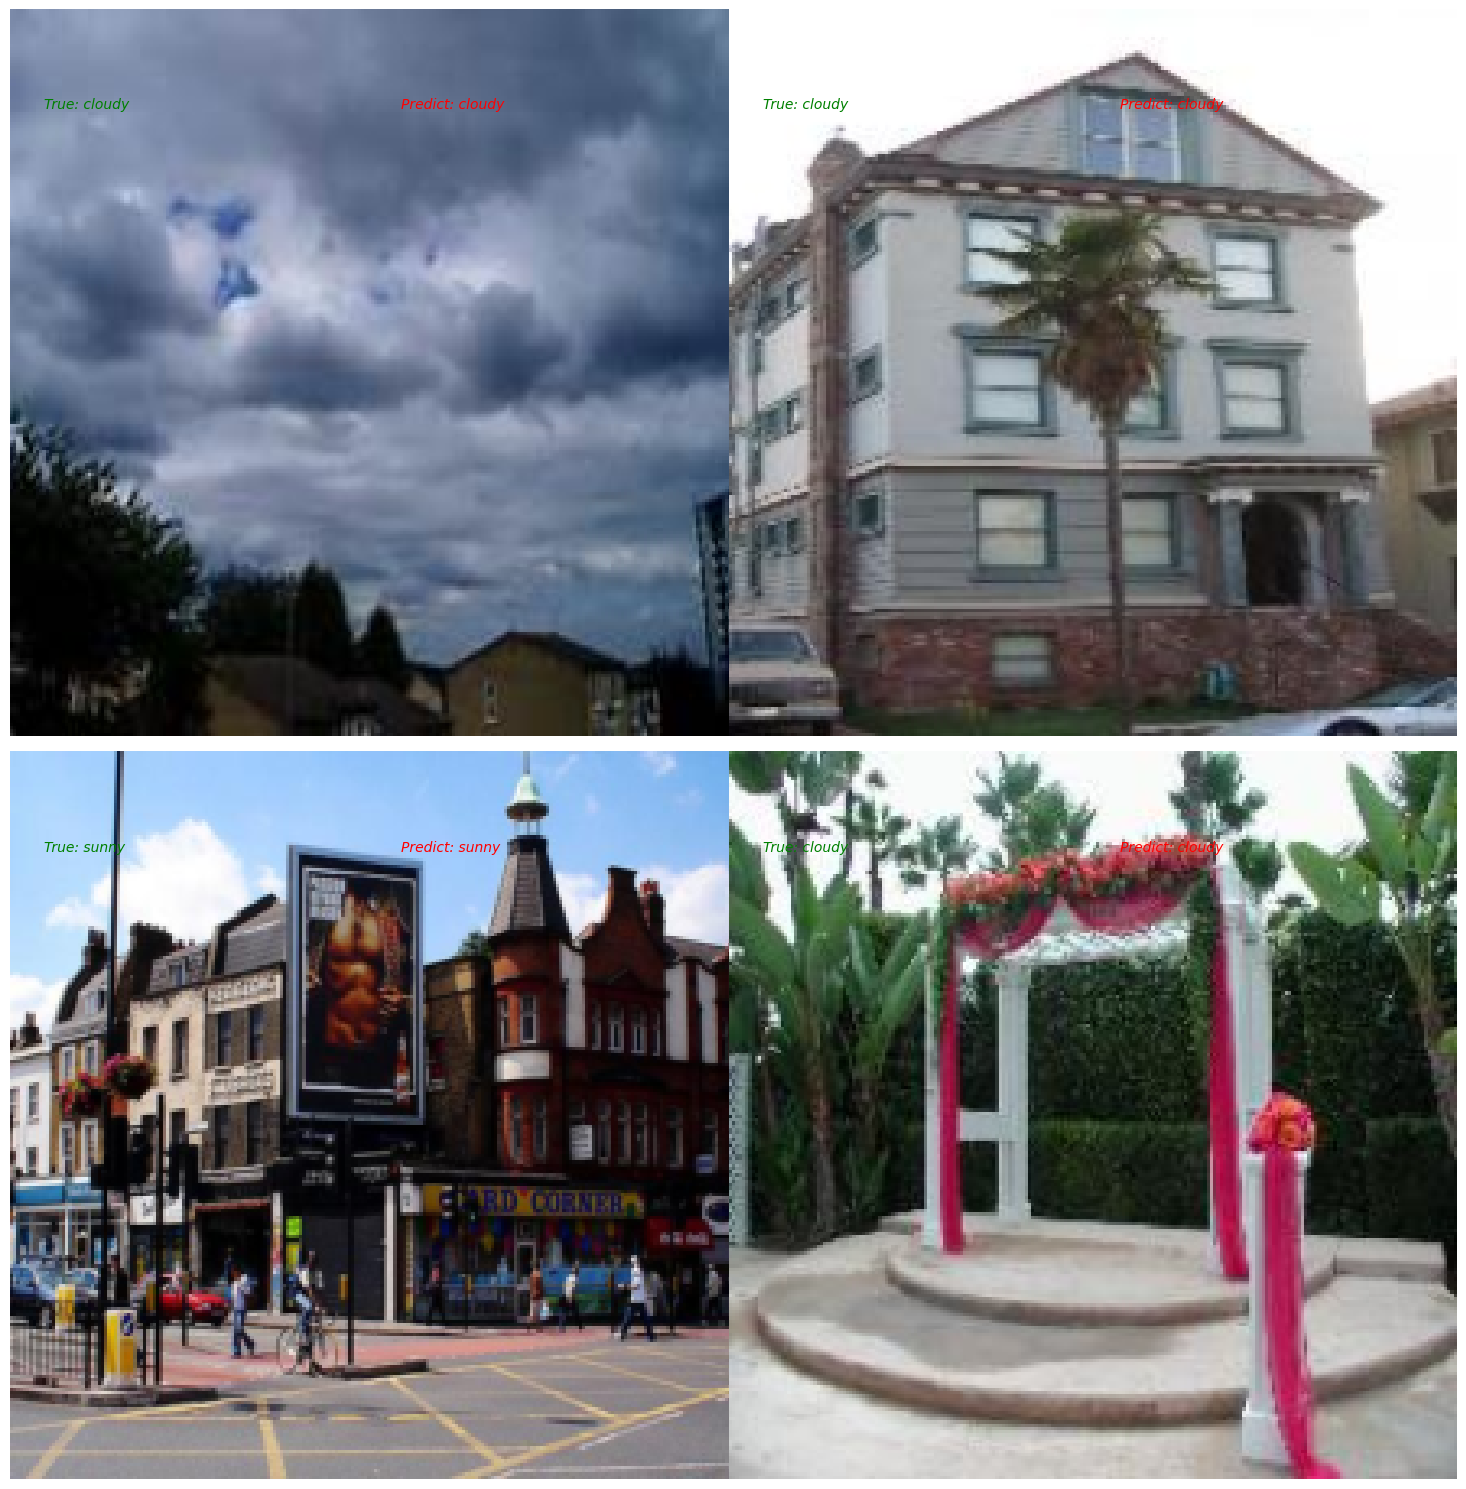

In [32]:


# Calculate the number of rows and columns for subplots
num_images = 4  # Number of images you want to visualize
num_rows = (num_images + 1) // 2
num_cols = min(2, num_images)

# Get a batch of validation data
imgs, labels = next(iter(val_dl))
output = model(imgs)

# Calculate predicted labels for the batch
pred_labels = output.argmax(1)

# Create subplots dynamically based on the number of images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)  # Adjust the spacing between subplots

axes = axes.flatten()

# Loop through the images and plot them with true and predicted labels
for i in range(num_images):
    ax = axes[i]
    ax.imshow(imgs[i].permute(1, 2, 0).numpy())
    ax.text(10, 30, "True: " + classes[labels[i].item()], style='italic', fontsize=10, color="green")
    ax.text(120, 30, "Predict: " + classes[pred_labels[i].item()], style='italic', fontsize=10, color="red")
    ax.axis("off")

# Hide any remaining empty subplots
for i in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("image_predictions.png")


# Evaluation

In [33]:
# Create a DataFrame to store predictions
#predictions = []

# Iterate through validation dataset
#for i, (imgs, labels) in enumerate(val_dl):
    #batch_size = imgs.shape[0]
    #outputs = model(imgs)
   # predicted_labels = outputs.argmax(1)

    #for j in range(batch_size):
       # filename = f"image_{i * batch_size + j}.jpg"  # Assuming a filename format
        #true_label = classes[labels[j].item()]
       # predicted_label = classes[predicted_labels[j].item()]

      #  predictions.append((filename, true_label, predicted_label))

# Convert predictions list to a DataFrame
#predictions_df = pd.DataFrame(predictions, columns=["Filename", "True Label", "Predicted Label"])

# Save predictions to a CSV file
#predictions_df.to_csv("predictions.csv", index=False)

In [34]:
num_classes = len(classes)
print("Number of classes:", num_classes)


Number of classes: 5


In [35]:
num_classes = 5  # Number of classes
num_images = len(val_dl.dataset)
y_true = np.empty((num_images,))
y_probs = np.empty((num_images, num_classes))  # Initialize with the correct number of classes

for i, (imgs, labels) in enumerate(val_dl):
    output = model(imgs)
    output = F.softmax(output, dim=1)

    y_true[i * val_dl.batch_size: (i + 1) * val_dl.batch_size] = labels.numpy()
    y_probs[i * val_dl.batch_size: (i + 1) * val_dl.batch_size] = output.detach().numpy()

# Create a DataFrame to store predictions
columns = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny','y_true']  # Include 'y_true' in columns
data = np.concatenate([y_probs, y_true.reshape(-1, 1)], axis=1)
predictions = pd.DataFrame(data=data, columns=columns)
predictions.head()


,cloudy,foggy,rainy,snowy,sunny,y_true
0,0.988362,0.000141,0.003882,0.000183,0.007431,0.0
1,0.000287,0.000091,0.995647,0.003860,0.000116,2.0
2,0.775991,0.000097,0.000174,0.000158,0.223581,4.0
3,0.952449,0.000556,0.038443,0.006072,0.002480,0.0
4,0.008336,0.725868,0.258032,0.005780,0.001983,1.0


In [36]:
predictions.to_csv("predictions.csv",index=False)

In [37]:
y_prob=predictions.iloc[:,:-1].values
y_pred=y_prob.argmax(1).astype(np.int16)
y_true=predictions.iloc[:,-1].values.astype(np.int16)

In [38]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1310
           1       0.89      0.93      0.91       261
           2       0.84      0.92      0.87       378
           3       0.88      0.93      0.90       375
           4       0.95      0.90      0.92      1284

    accuracy                           0.90      3608
   macro avg       0.89      0.91      0.90      3608
weighted avg       0.91      0.90      0.90      3608



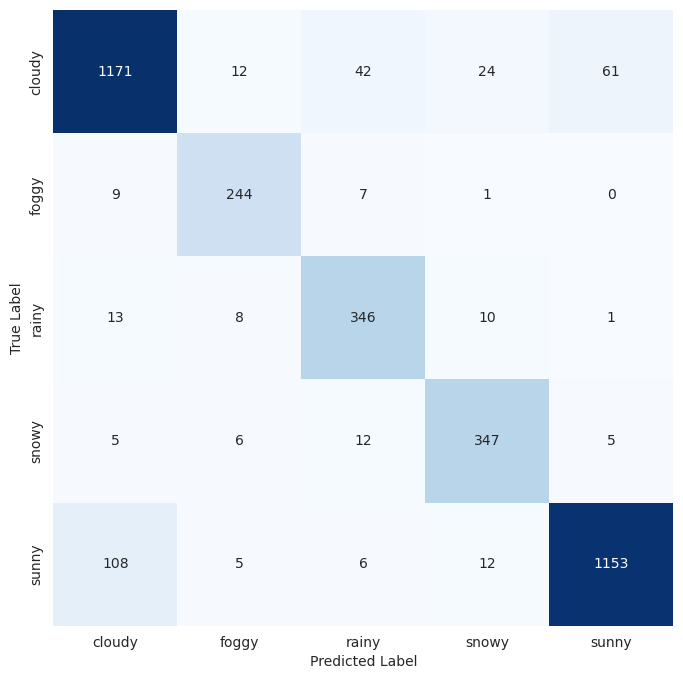

In [39]:
plt.figure(figsize=(8,8));
val=['cloudy','foggy','rainy','snowy','sunny']
plot_data=pd.DataFrame(confusion_matrix(y_true,y_pred),columns=val,index=val)

sns.heatmap(plot_data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');
plt.savefig("7.png");

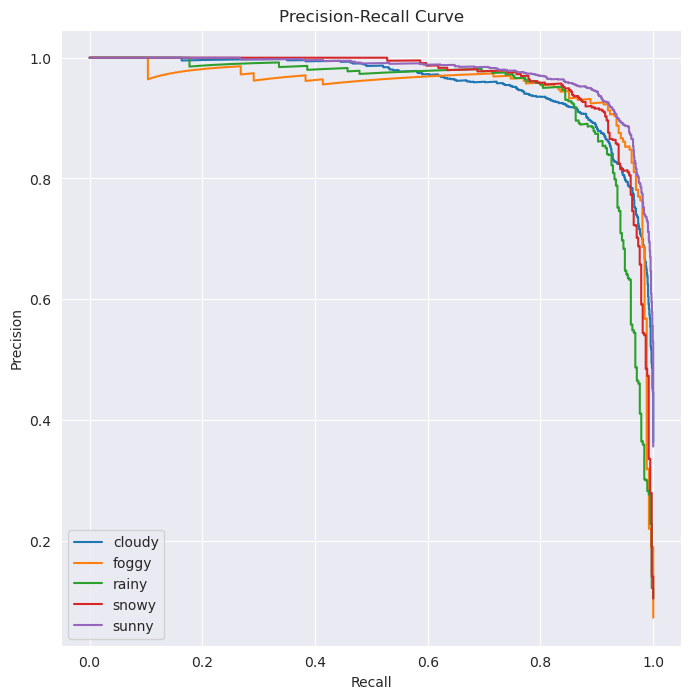

In [40]:
plt.figure(figsize=(8, 8))

for i in range(y_probs.shape[1]):  # Use y_probs.shape[1] instead of y_prob.shape[1]
    y_binary = (y_true == i)
    precision, recall, _ = precision_recall_curve(y_binary, y_probs[:, i])
    plt.plot(recall, precision, label=val[i])

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig("8.png")
